## Import required libraries:

In [194]:
import warnings
warnings.filterwarnings('ignore')

In [195]:
import pandas as pd
import tsfresh as ts
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
import pickle
from collections import OrderedDict
%matplotlib inline

## Load and Store current state of object:

In [196]:
#Functions to save objects for later use and retireve it
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".pkl","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".pkl","rb"))
    return temp


## Load Preprocessed Data:

In [197]:
jan_2015_smooth=openfromfile('jan_2015_smooth')
jan_2016_smooth=openfromfile('jan_2016_smooth')
kmeans=openfromfile('kmeans')
regions_cum=openfromfile('regions_cum')

In [198]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [199]:
ratios_jan.shape

(133920, 3)

In [200]:
ratios_jan.head(5)

,Given,Prediction,Ratios
0,191,207,1.083770
1,381,315,0.826772
2,403,383,0.950372
3,374,364,0.973262
4,400,362,0.905000


# Models:

## 1.Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

## Function for BaseLine models:

### [1.1]Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [201]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            # initially / start we dont have past data so ratio=0
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        #when we past data is available predicted_ratio is avg of all past ration in a recent window
        predicted_ratio_values.append(predicted_ratio)# when i=1 we append ratio at i=0, after i=0 append avg ratio
        #p(t)_2016 = p(t)_2015 * R(t)_2016
        #where R(t)_2016 is calculated using past r(t-1),R(t-2),-----so on
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            # moving avg of past ratio, here in slicing i+1 is used bcz slice start from begin to end-1,
            # divide by (i+1) bcz we started i from 0, and avg count from 1.
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [202]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 1 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

### [1.2]Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [203]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [204]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2016 values therefore we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

### [1.3]Exponential  Weighted Moving Averages
 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [205]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [206]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

# Applying Baseline Models:

In [207]:
ratios_jan, mape_sma_r, mse_sma_r = MA_R_Predictions(ratios_jan,'jan')
ratios_jan, mape_sma_p, mse_sma_p = MA_P_Predictions(ratios_jan,'jan')
ratios_jan, mape_wma_r, mse_wma_r = WA_R_Predictions(ratios_jan,'jan')
ratios_jan, mape_wma_p, mse_wma_p = WA_P_Predictions(ratios_jan,'jan')
ratios_jan, mape_ewma_r, mse_ewma_r = EA_R1_Predictions(ratios_jan,'jan')
ratios_jan, mape_ewma_p, mse_ewma_p = EA_P1_Predictions(ratios_jan,'jan')

## Summary of baseline models:
We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [208]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("-------------------------------------------------------------------------------------------")
#print(model_summary)
print ("Moving Averages (Ratios) -                             MAPE: %.3f"%(100*mape_sma_r),"      MSE: %.4f"%mse_sma_r)
print ("Moving Averages (2016 Values) -                        MAPE: %.3f"%(100*mape_sma_p),"      MSE: %.4f"%mse_sma_p)
print ("-------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: %.3f"%(100*mape_wma_r),"      MSE: %.4f"%mse_wma_r)
print ("Weighted Moving Averages (2016 Values) -               MAPE: %.3f"%(100*mape_wma_p),"      MSE: %.4f"%mse_wma_p)
print ("-------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -                 MAPE: %.3f"%(100*mape_ewma_r),"      MSE: %.4f"%mse_ewma_r)
print ("Exponential Moving Averages (2016 Values) -            MAPE: %.3f"%(100*mape_ewma_p),"      MSE: %.4f"%mse_ewma_p)

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
-------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE: 16.287       MSE: 496.6735
Moving Averages (2016 Values) -                        MAPE: 12.761       MSE: 236.2616
-------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE: 16.005       MSE: 486.8578
Weighted Moving Averages (2016 Values) -               MAPE: 12.195       MSE: 222.2438
-------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -                 MAPE: 15.975       MSE: 490.0153
Exponential Moving Averages (2016 Values) -            MAPE: 12.176       MSE: 221.1123


<b>Plese Note:-</b> The above comparisons are made using Jan 2015 and Jan 2016 only

From the above matrix it is inferred that the best forecasting model for our prediction would be:-
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e Exponential Moving Averages using 2016 Values

## 2.Regression Models

### [2.1]Preparing data for regression model:
1. cluster center lattitude
2. cluster center longitude
3. day of the week 
4. ft_1: number of pickups that are happened previous t-1th 10min intravel
5. ft_2: number of pickups that are happened previous t-2th 10min intravel
6. ft_3: number of pickups that are happened previous t-3th 10min intravel
7. ft_4: number of pickups that are happened previous t-4th 10min intravel
8. ft_5: number of pickups that are happened previous t-5th 10min intravel

In [209]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 4459 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
features = []
#tsne_feature=features

features = [0]*number_of_time_stamps
for i in range(0,30):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*4459)# bcz first 5 are used for given
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*4459)
    # jan 1st 2016 is friday, so we start our day from 4: "(int(k/144))%7+5"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+5)%7) for k in range(5,4464)])# 0,1,2,3,4 used as 
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    features = np.vstack((features, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
features = features[1:]

In [210]:
len(tsne_lat[0])*len(tsne_lat) == features.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 30*4459 == len(output)*len(output[0])

True

### [2.2] Feature Extraction:

### [2.2.1]Add exponential moving average as new feature to data for regression model:

In [211]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,30):
    for i in range(0,4464):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        #EWMA
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])#discarding 1st 5 values bcz 1st 5 values we used as given values to predict nxt 
    predicted_values=[]

### [2.2.2]Time series :

We plot our time series data to check whether it is having repetative pattern , If our time series have repetative pattern then we can able to use "Fourier Transform" to create new features .

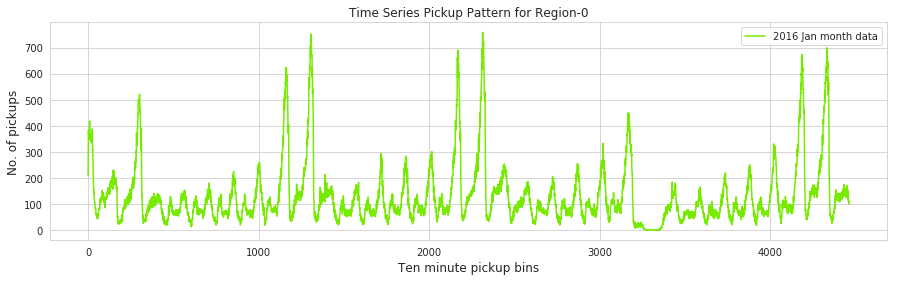

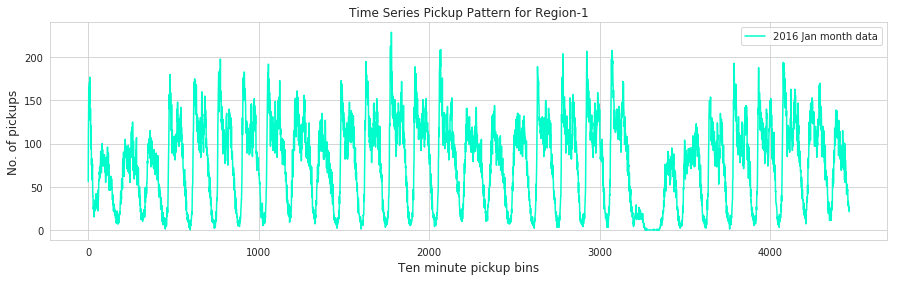

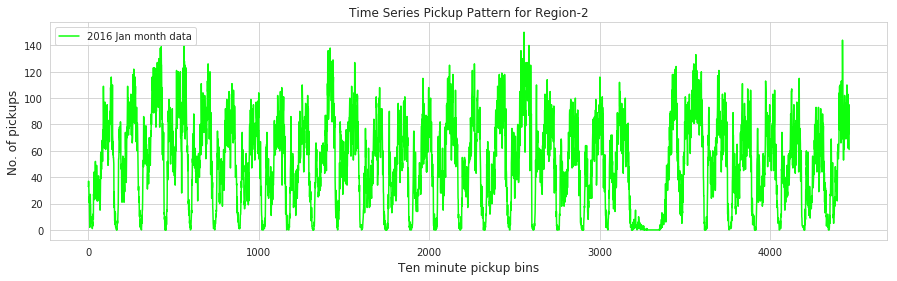

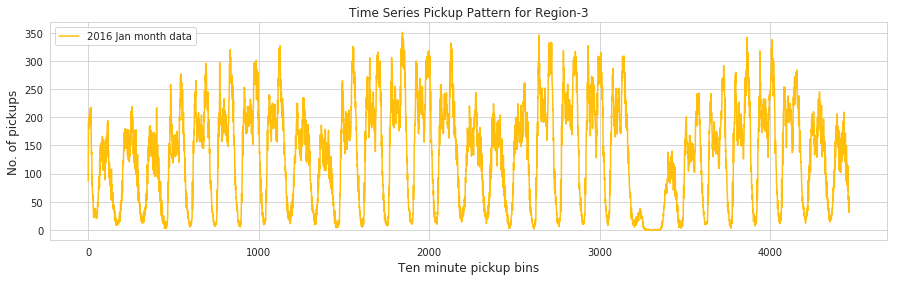

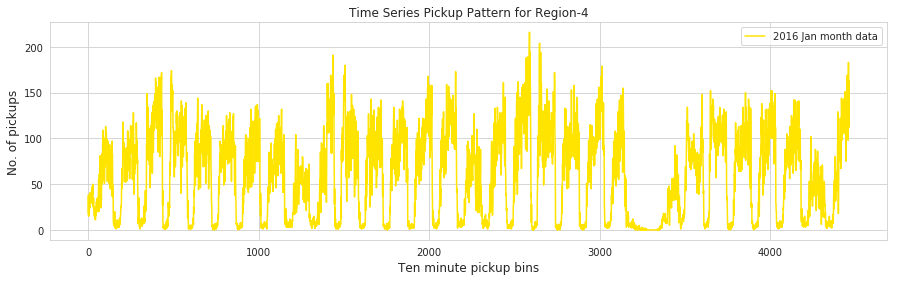

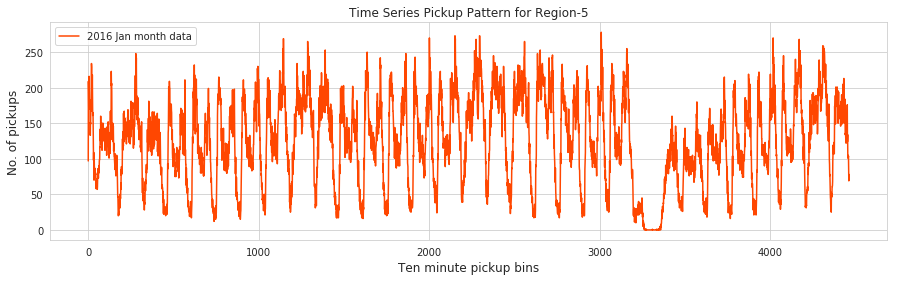

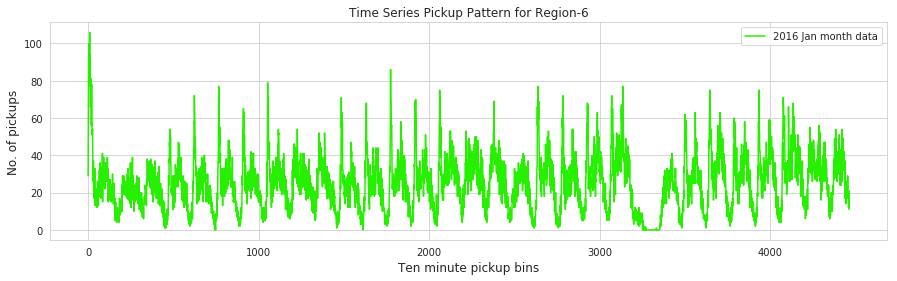

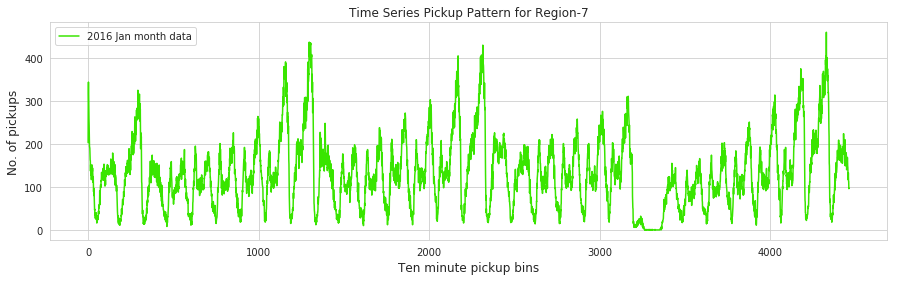

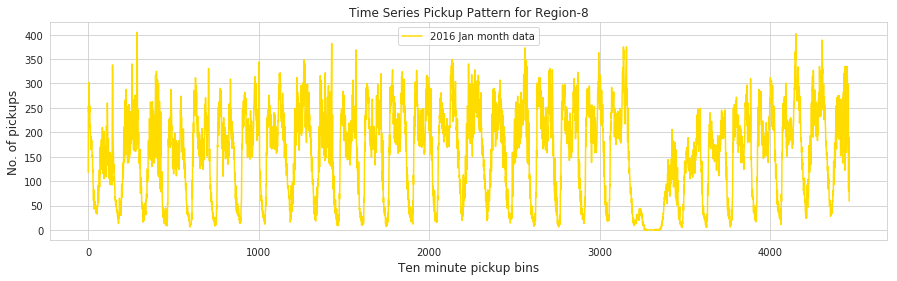

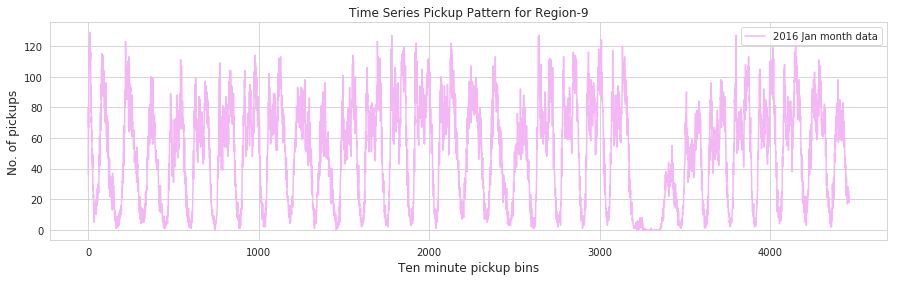

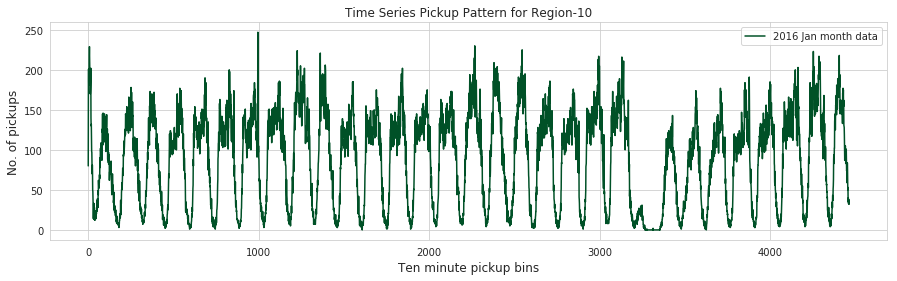

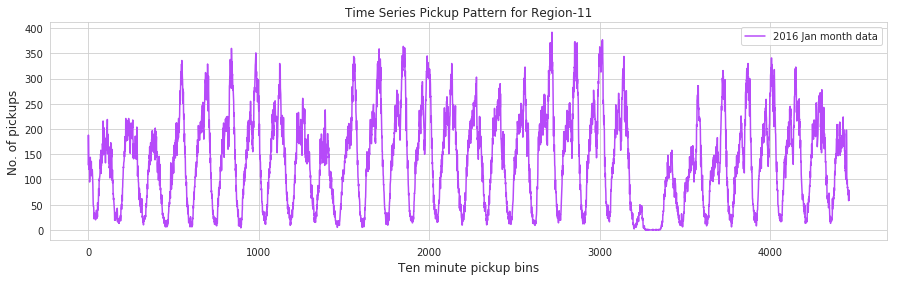

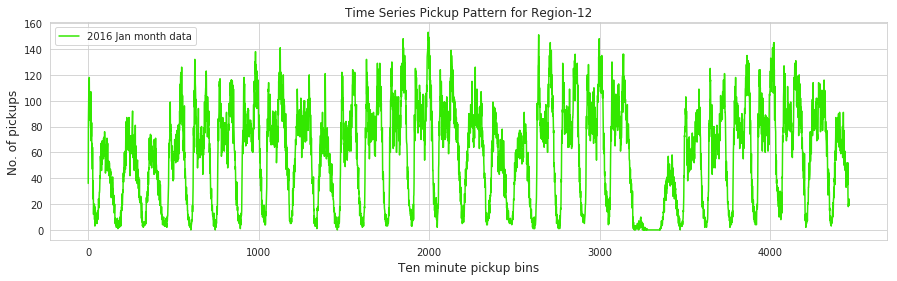

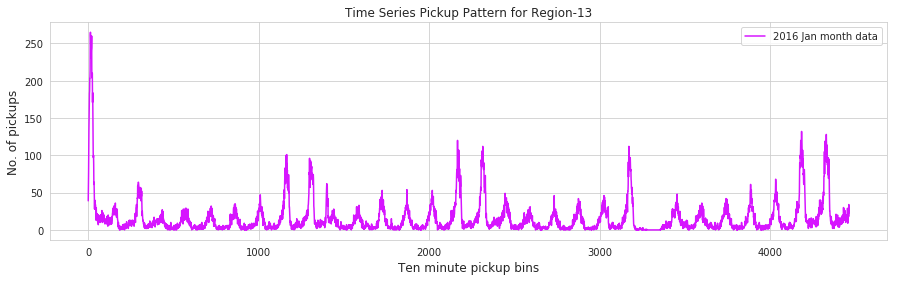

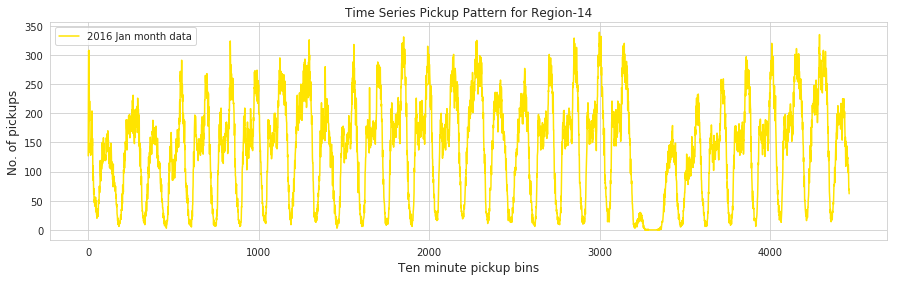

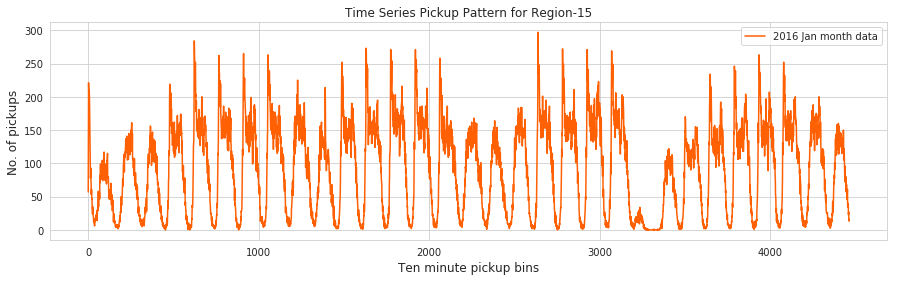

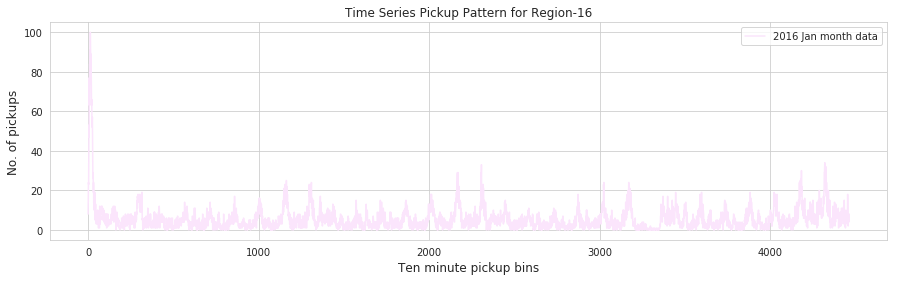

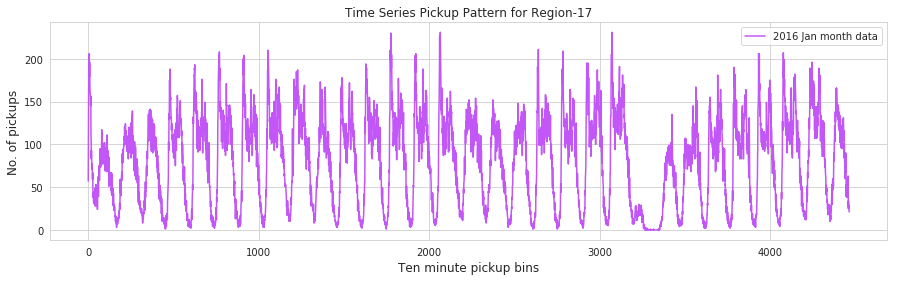

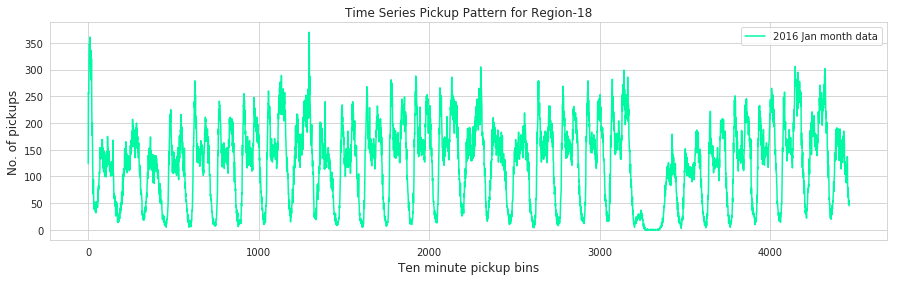

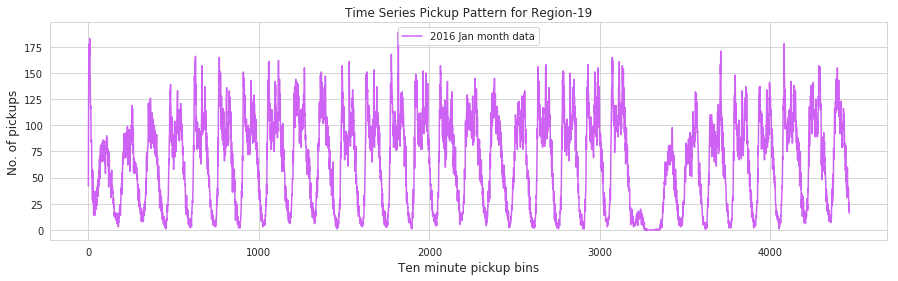

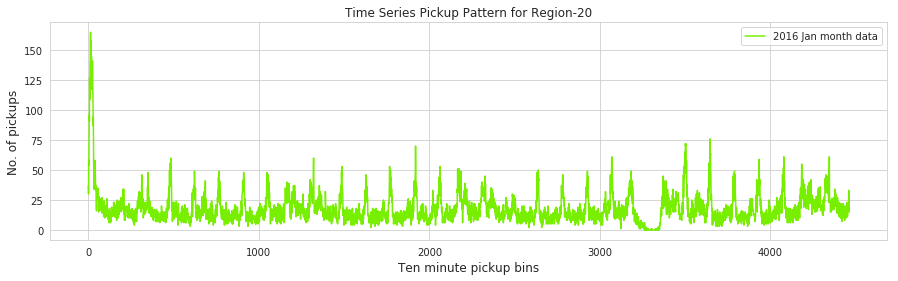

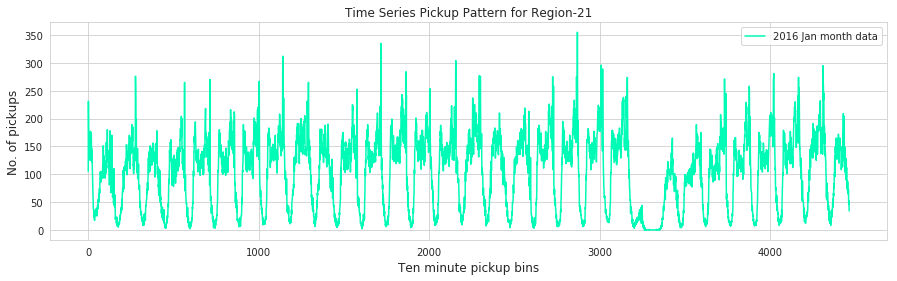

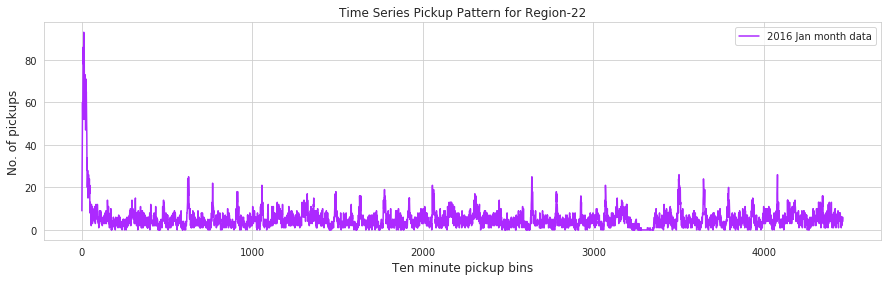

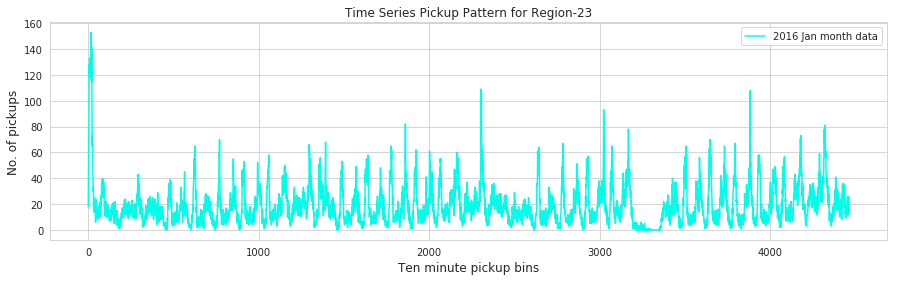

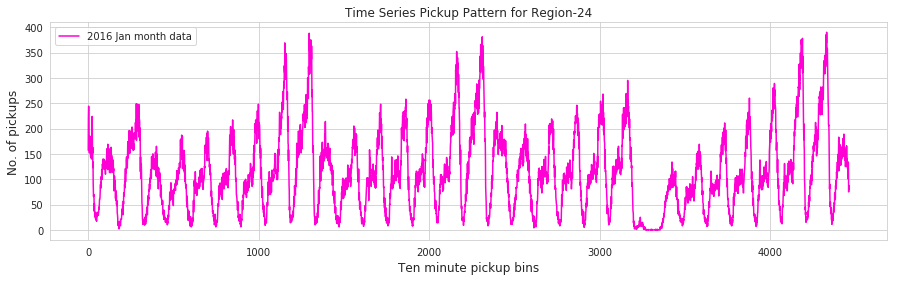

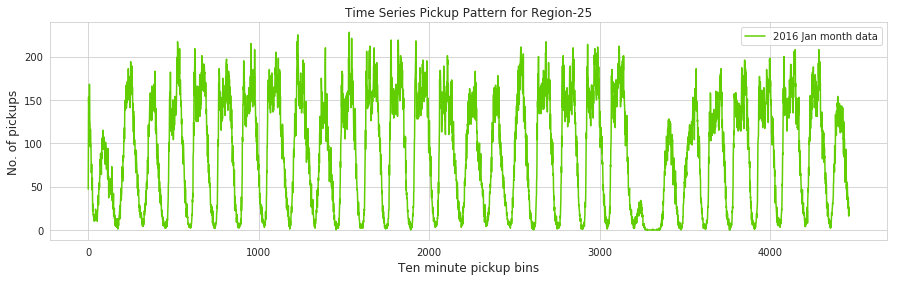

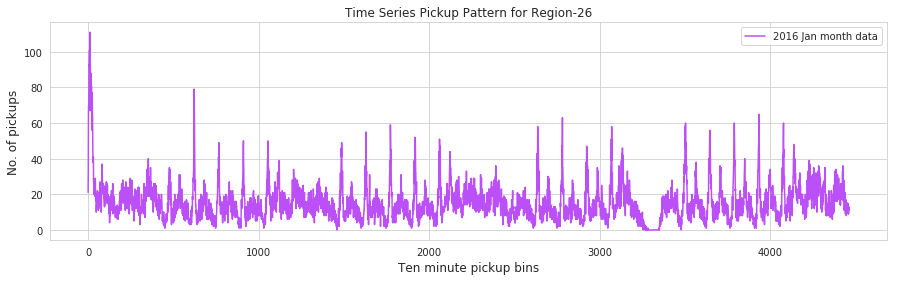

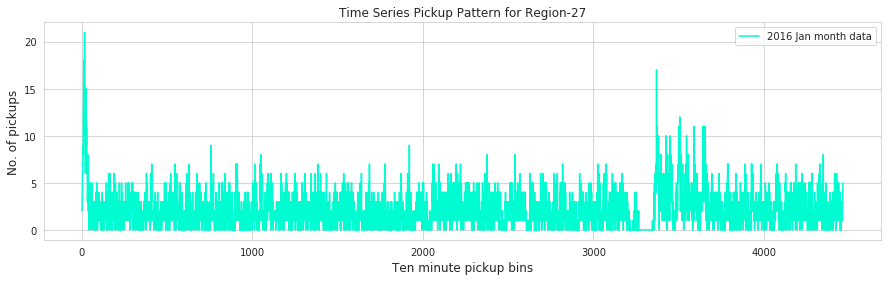

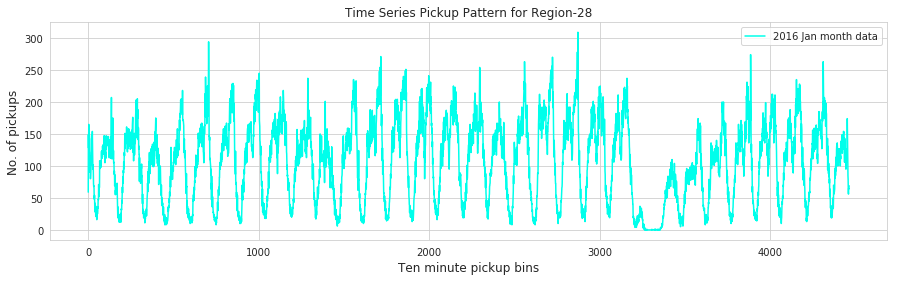

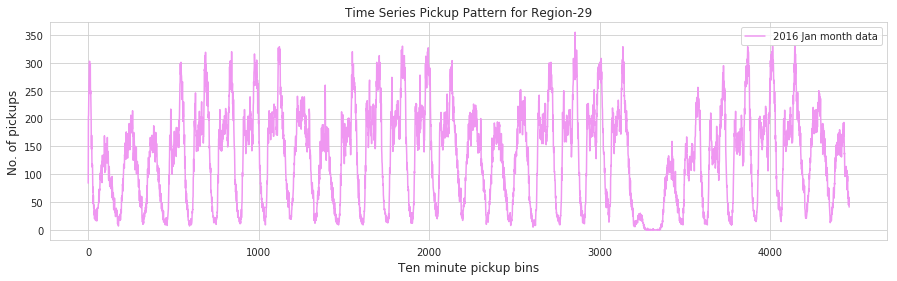

In [212]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
#second_x = list(range(4464,8640))
#third_x = list(range(8640,13104))
for i in range(30):
    plt.figure(figsize=(15,4))
    sns.set_style('whitegrid')
    plt.title('Time Series Pickup Pattern for Region-%d'%i, size=12)
    plt.xlabel('Ten minute pickup bins', fontsize=12)
    plt.ylabel('No. of pickups', fontsize=12)
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    #plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    #plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

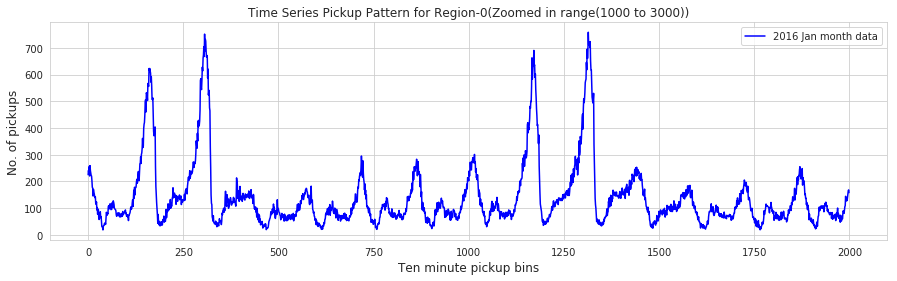

In [215]:
plt.figure(figsize=(15,4))
sns.set_style('whitegrid')
plt.title('Time Series Pickup Pattern for Region-0(Zoomed in range(1000 to 3000))', size=12)
plt.xlabel('Ten minute pickup bins', fontsize=12)
plt.ylabel('No. of pickups', fontsize=12)
plt.plot(np.arange(2000),regions_cum[0][1000:3000], color='blue',label='2016 Jan month data')
plt.legend()
plt.show()

### Observation:
1. From the above time series for no. of pickups in 24 hours, we observed that it have repetative behaviour so we can use fourier transform to build new features.  

### [2.2.2.1] Fourier Transform:
Fourier Transform decompose a signal into  sum of sine and cosine waves of different amplitudes and frequencies. 
1. Here we are using DFT(using fast fourier transform algorithm) to create the following features:
        a. Top five amplitudes/peaks present in digital signal.
        b. Top five frequencies corresponds to top five amplitudes.
        c. Angle corresponds to top five amplitudes.

### [a.]Spectrum of TimeSeries of Pickups of Region:

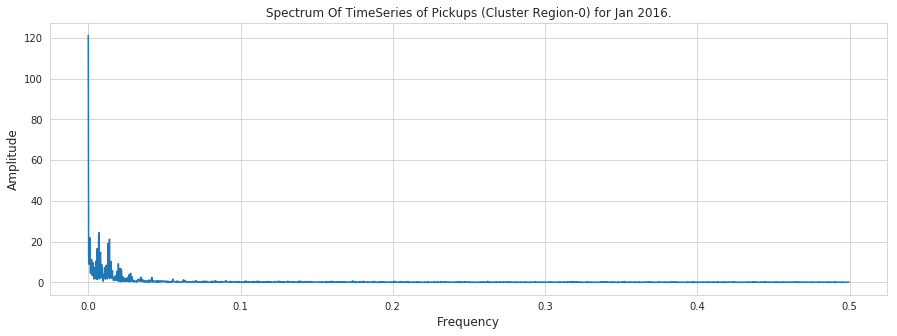

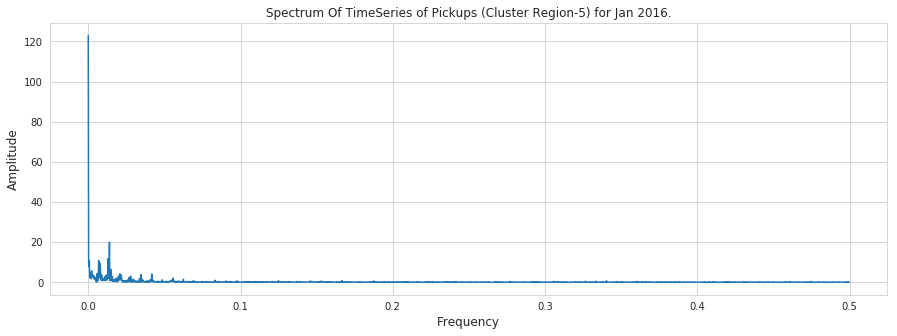

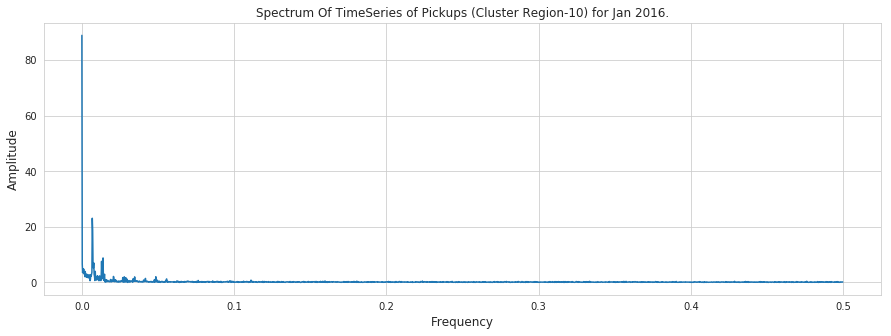

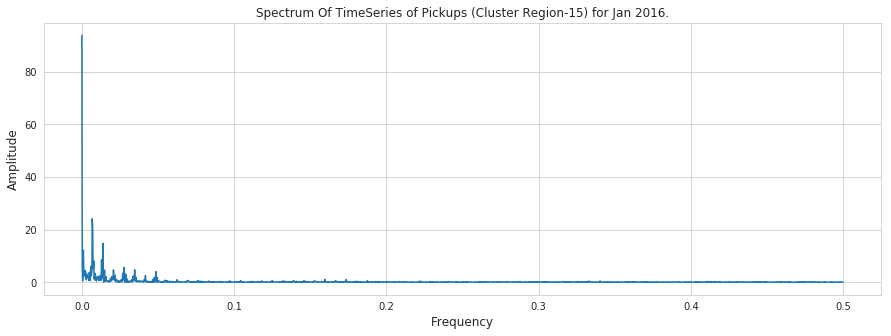

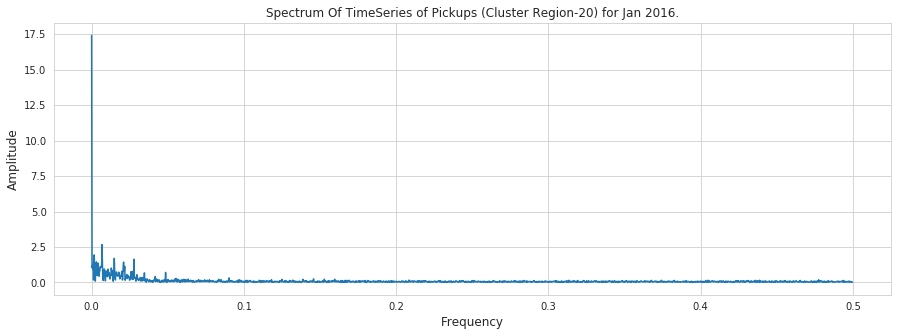

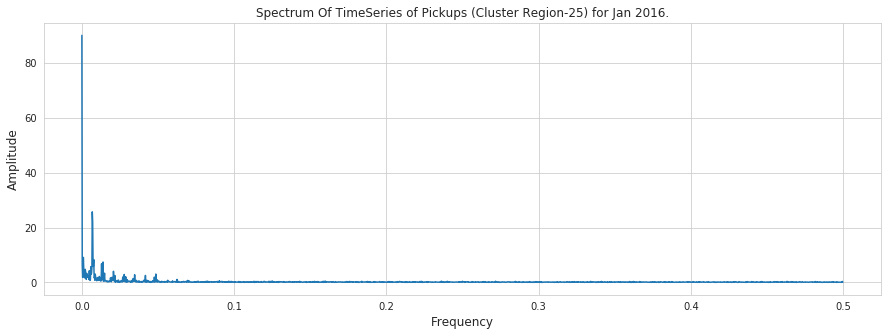

In [216]:
N=2**12
for i in range(0,30,5):
    Y = np.fft.fft(np.array(regions_cum[i])[0:N])/N
    # read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html 
    amp=abs(Y[0:int(N/2)])
    freq = np.fft.fftfreq(N, 1)[0:int(N/2)]
    n = len(freq)
    plt.figure(figsize = (15, 5))
    plt.plot(freq[:], amp[:])
    plt.xlabel("Frequency",fontsize=12)
    plt.ylabel("Amplitude",fontsize=12)
    plt.title("Spectrum Of TimeSeries of Pickups (Cluster Region-%d) for Jan 2016."%i,size=12)
    plt.show()

### [b.]Feature engineering using DFT:

In [217]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
# The FFT algorithm is much more efficient if the number of data points is a power of 2 (128, 512, 1024, etc.)
'''
sno.   cluster   f1 , f2 , f3 , f4 , f5
1      0         x    y    z    a    b
2      0         x    y    z    a    b
3      0         x    y    z    a    b
4      0         x    y    z    a    b
5      0         x    y    z    a    b
.      .         .    .    .    .    .
.      .         .    .    .    .    .
.      .         .    .    .    .    .
.      .         .    .    .    .    .
4459   0         x    y    z    a    b
'''
N=2**12
amplitude_lists=[]
frequency_lists=[]
angle_lists=[]
for i in range(0,30):
    # divided by N bcz numpy implementation of FFT doesnt consider 1/N
    Y = np.fft.fft(np.array(regions_cum[i])[0:N])/N
    # read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
    freq = np.fft.fftfreq(N, 1)[1:int(N/2)]
    # top 5 amplitude 
    amplitude=abs(Y)[1:int(N/2)]
    # phase of signal
    angle= np.angle(Y)[1:int(N/2)]

    #TOP 5-MAX AMPLITUDE/PEAKS
    top_5_amp = amplitude[np.argsort(amplitude)[::-1]][:5]
    #ANGLE CORRESPONDS TO FOURIER COFFICIENT OF WHICH GIVE MAX AMPLITUDE
    top_5_angle=angle[np.argsort(amplitude)[::-1]][:5]#np.argsort(angle)
    #TOP-5 FREQ CORRESPONDING TO MAX AMP
    top_5_freq = freq[np.argsort(amplitude)[::-1]][:5]
    # for each cluster we have 5 freq, 5 ampli, 5 phase and these freq,amp,phase are same for all pickup_bin in a cluster
    #bcz we know that a wave have a freq and in our case that wave is TimeSeries of pickups for a cluster
    for k in range(4459):
        amplitude_lists.append(top_5_amp)
        frequency_lists.append(top_5_freq)
        angle_lists.append(top_5_angle)


## Holt Winters Model:

1. Each Time series dataset can be decomposed into it’s componenets which are Trend, Seasonality and Residual. 
2. Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality. In our case timeseries of pickups have some sort of seasonality we can observe from timeseries plot.
3. Holt winter takes into account both trend and seasonality to forecast future prices.


ℓx=α(yx−sx−L)+(1−α)(ℓx−1+bx−1)  :level

bx=β(ℓx−ℓx−1)+(1−β)bx−1         :trend

sx=γ(yx−ℓx)+(1−γ)sx−L           :seasonal

y^x+m=ℓx+mbx+sx−L+1+(m−1)modL   :forecast

where: smoothing parameter
0<=α,β,γ<=1

4. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — one for the level ℓt, one for trend bt and one for the seasonal component denoted by st, with smoothing parameters α, β and γ.
5. 
        a. level: equation shows a weighted average between the seasonally adjusted observation and the non-seasonal forecast for time t. 
        b. trend: equation is identical to Holt’s linear method. 
        c. seasonal: equation shows a weighted average between the current seasonal index, and the seasonal index of the same season last year (i.e., s time periods ago).

In [218]:
#reference links:
#https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
#https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/

def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result


In [272]:
alpha = 0.9
beta = 0.2
gamma = 0.45
season_len = 30

holts_predicted_list = []
for r in range(0,30):
    holts_predict_values = triple_exponential_smoothing(regions_cum[r][0:4464], season_len, alpha, beta, gamma, 0)
    holts_predicted_list.append(holts_predict_values[5:])# first 5 used as initial seen points to predict nxt
len(holts_predicted_list[0])

4459

## Sainity check for optimal alpha, optimal beta and gamma values by using timeseries:

Enter region no.:0


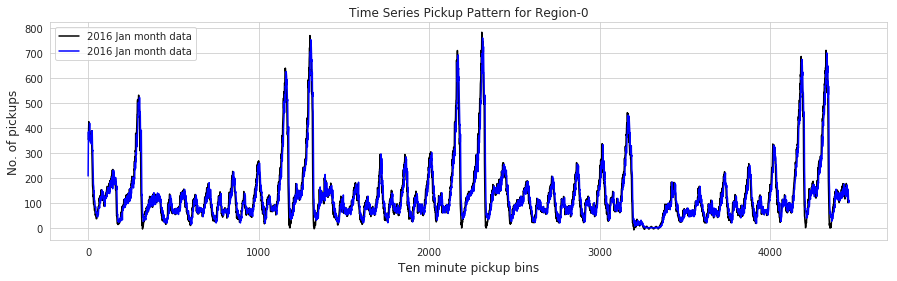

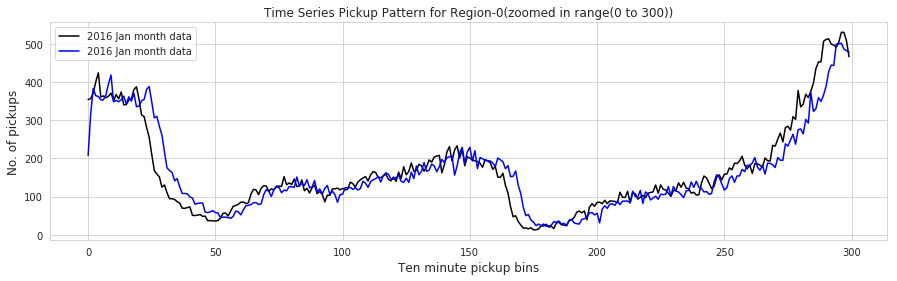

In [220]:
region_no=int(input('Enter region no.:'))
#range_=int(input('Enter No. of smples to be plot(<4459):'))
for i in range(2):
    plt.figure(i,figsize=(15,4))
    sns.set_style('whitegrid')
    plt.xlabel('Ten minute pickup bins', fontsize=12)
    plt.ylabel('No. of pickups', fontsize=12)
    
    if i ==1:
        plt.title('Time Series Pickup Pattern for Region-%d(zoomed in range(0 to 300))'%region_no, size=12)
        plt.plot(np.arange(300),predict_list_2[region_no][0:300], color='black',label='2016 Jan month data')
        plt.plot(np.arange(300),regions_cum[region_no][:300], color='blue',label='2016 Jan month data')
    else:
        plt.title('Time Series Pickup Pattern for Region-%d'%region_no, size=12)
        plt.plot(np.arange(4459),predict_list_2[region_no][0:4459], color='black',label='2016 Jan month data')
        plt.plot(np.arange(4464),regions_cum[region_no][:4464], color='blue',label='2016 Jan month data')
    plt.legend()
    plt.show()

### Observation:
1. After trying lot of values for alpha, beta and gamma:
        a. optimal alpha= .9
        b. optimal beta= .2
        c. optimal gamma= .45
For these optimal values we observe that our prediction and actual timeseries are almost overlapped.

### [2.3]Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [221]:
# train, test split : 70% 30% split
# 1st 5-pickup_bins are used as given data we used it for predict nxt #pickups
# 4459(pickup_bins) * 30(clusters) = 133,770
# 4459 * 30 * .7 = 93639 = total train data
# 4459 * 30 * .3 = 40131 = total test data
# 4459 * .7 = 3121
# 4459 * .3 = 1337
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(4459*30*0.7))
print("size of test data :", int(4459*30*0.3))

size of train data : 93639
size of test data : 40131


In [222]:
# extracting first 3121 timestamp values i.e 70% of 4459 (total timestamps) for our training data
train_features =  [features[i*4459:(4459*i+3121)] for i in range(0,30)]
# temp = [0]*(12955 - 9068)
test_features = [features[(4459*(i))+3121:4459*(i+1)] for i in range(0,30)]

In [223]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]),\
      "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]),\
      "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 30 Number of data points in trian data 3121 Each data point contains 5 features
Number of data clusters 30 Number of data points in test data 1338 Each data point contains 5 features


In [250]:
train_frequencies = [frequency_lists[i*4459:(4459*i+3121)] for i in range(30)]
test_frequencies = [frequency_lists[(i*4459)+3121:(4459*(i+1))] for i in range(30)]

train_amplitudes = [amplitude_lists[i*4459:(4459*i+3121)] for i in range(30)]
test_amplitudes = [amplitude_lists[(i*4459)+3121:(4459*(i+1))] for i in range(30)]

train_angles = [angle_lists[i*4459:(4459*i+3121)] for i in range(30)]
test_angles = [angle_lists[(i*4459)+3121:(4459*(i+1))] for i in range(30)]


In [251]:
train_amplitudes[0]
len(test_angles[0])

1338

In [273]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:3121] for i in tsne_lat] # we have 30 sublist containing 3121 value in each list
tsne_train_flat_lon = [i[:3121] for i in tsne_lon]
tsne_train_flat_weekday = [i[:3121] for i in tsne_weekday]
tsne_train_flat_output = [i[:3121] for i in output]
tsne_train_flat_exp_avg = [i[:3121] for i in predict_list]
tsne_train_holts = [i[:3121] for i in holts_predicted_list]

In [274]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[3121:] for i in tsne_lat]
tsne_test_flat_lon = [i[3121:] for i in tsne_lon]
tsne_test_flat_weekday = [i[3121:] for i in tsne_weekday]
tsne_test_flat_output = [i[3121:] for i in output]
tsne_test_flat_exp_avg = [i[3121:] for i in predict_list]
tsne_test_holts = [i[3121:] for i in holts_predicted_list]

In [275]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
test_new_features = []
train_amp = []
test_amp = []
train_freq = []
test_freq = []
train_ang = []
test_ang = []
train_holt = []
test_holt = []
#creating single list
for i in range(0,30):
    train_new_features.extend(train_features[i])
    test_new_features.extend(test_features[i])
    train_amp.extend(train_amplitudes[i])
    test_amp.extend(test_amplitudes[i])
    train_freq.extend(train_frequencies[i])
    test_freq.extend(test_frequencies[i])
    train_ang.extend(train_angles[i])
    test_ang.extend(test_angles[i]) 
    train_holt.extend(tsne_train_holts[i])
    test_holt.extend(tsne_test_holts[i])

In [276]:
len(train_holt)

93630

In [277]:
train_data = np.hstack((train_freq, train_amp, train_ang,train_new_features))
test_data = np.hstack((test_freq, test_amp, test_ang, test_new_features))

In [279]:
# converting lists of lists into single list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])
tsne_train_holts_ = sum(tsne_train_holts,[])

In [280]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])
tsne_test_holts_ = sum(tsne_test_holts,[])

In [281]:
# Preparing the data frame for our train data
columns = ['freq_1', 'freq_2', 'freq_3', 'freq_4', 'freq_5',\
           'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_5',\
           'ang_1', 'ang_2', 'ang_3', 'ang_4', 'ang_5',\
           'ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1']
           #'ang_1', 'ang_2', 'ang_3', 'ang_4', 'ang_5',\
x_train = pd.DataFrame(data=train_data, columns=columns) 
x_train['lat'] = tsne_train_lat
x_train['lon'] = tsne_train_lon
x_train['weekday'] = tsne_train_weekday
x_train['exp_avg'] = tsne_train_exp_avg
x_train['holt_triplet_avg']=tsne_train_holts_
print(x_train.shape)

(93630, 25)


In [282]:
x_train.head(5)

,freq_1,freq_2,freq_3,freq_4,freq_5,amp_1,amp_2,amp_3,amp_4,amp_5,...,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,holt_triplet_avg
0,0.00708,0.006836,0.000977,0.013916,0.012939,24.4252,22.911823,22.06076,21.227861,19.011012,...,207.0,315.0,383.0,364.0,362.0,40.725507,-73.986497,5,361,363.583011
1,0.00708,0.006836,0.000977,0.013916,0.012939,24.4252,22.911823,22.06076,21.227861,19.011012,...,315.0,383.0,364.0,362.0,353.0,40.725507,-73.986497,5,355,360.422146
2,0.00708,0.006836,0.000977,0.013916,0.012939,24.4252,22.911823,22.06076,21.227861,19.011012,...,383.0,364.0,362.0,353.0,353.0,40.725507,-73.986497,5,353,373.428384
3,0.00708,0.006836,0.000977,0.013916,0.012939,24.4252,22.911823,22.06076,21.227861,19.011012,...,364.0,362.0,353.0,353.0,366.0,40.725507,-73.986497,5,362,405.630446
4,0.00708,0.006836,0.000977,0.013916,0.012939,24.4252,22.911823,22.06076,21.227861,19.011012,...,362.0,353.0,353.0,366.0,395.0,40.725507,-73.986497,5,385,431.319841


In [283]:
# Preparing the data frame for our train data
x_test = pd.DataFrame(data=test_data, columns=columns) 
x_test['lat'] = tsne_test_lat
x_test['lon'] = tsne_test_lon
x_test['weekday'] = tsne_test_weekday
x_test['exp_avg'] = tsne_test_exp_avg
x_test['holt_triplet_avg']=tsne_test_holts_
print(x_test.shape)

(40140, 25)


In [284]:
x_test.head()

,freq_1,freq_2,freq_3,freq_4,freq_5,amp_1,amp_2,amp_3,amp_4,amp_5,...,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,holt_triplet_avg
0,0.00708,0.006836,0.000977,0.013916,0.012939,24.4252,22.911823,22.06076,21.227861,19.011012,...,70.0,66.0,64.0,81.0,65.0,40.725507,-73.986497,5,68,106.936369
1,0.00708,0.006836,0.000977,0.013916,0.012939,24.4252,22.911823,22.06076,21.227861,19.011012,...,66.0,64.0,81.0,65.0,104.0,40.725507,-73.986497,5,93,106.322705
2,0.00708,0.006836,0.000977,0.013916,0.012939,24.4252,22.911823,22.06076,21.227861,19.011012,...,64.0,81.0,65.0,104.0,102.0,40.725507,-73.986497,5,99,113.268938
3,0.00708,0.006836,0.000977,0.013916,0.012939,24.4252,22.911823,22.06076,21.227861,19.011012,...,81.0,65.0,104.0,102.0,109.0,40.725507,-73.986497,5,106,126.491973
4,0.00708,0.006836,0.000977,0.013916,0.012939,24.4252,22.911823,22.06076,21.227861,19.011012,...,65.0,104.0,102.0,109.0,121.0,40.725507,-73.986497,5,116,130.464141


## [2.4]Utility functions required for regression models

### [a.]Function for Standardizing data

In [285]:
def std_data(train,test,mean):
    scaler=StandardScaler(with_mean=mean)
    std_train=scaler.fit_transform(train)
    std_test=scaler.transform(test)
    return std_train, std_test

### [b.]Function to print parameters summary:

In [286]:
def param_list(params, para_summ):
    para_summ.clear_rows()
    for name, val in zip(params.keys(),params.values()):
        para_summ.add_row([name, val])
    print(para_summ)

### [c.]Function for feature importance:

In [287]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 15)
    plt.ylabel("Features", fontsize = 15)
    plt.title("Feature Importance", fontsize = 15)
    plt.tick_params(labelsize = 15)
    
    plt.show()

### [d.]function for scorer for Grid search and Random search:

In [288]:
#(mean_absolute_error(y_true, y_pred))/(sum(y_true)/len(y_pred))*100
def mape_scorer(y_true, y_pred):
    #to avoid division by zero error
    eps=.000001
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape=(mean_absolute_error(y_true, y_pred))/(sum(y_true)/len(y_pred))*100
    #mape = (mean_absolute_error(y_true,y_pred)/sum(y_true))*(100/len(y_pred))
    return mape

### [e.]Function for hyperparam tunning for linear regression:
### Linear-Regression

In [289]:
def linearRegressor(x_train,y_train,CV,params_):
    clf=SGDRegressor(loss='squared_loss', penalty='l2')
    model=GridSearchCV(clf,\
                       param_grid=params_,\
                       n_jobs=-1,\
                       return_train_score=True,\
                       scoring=make_scorer(mape_scorer, greater_is_better=False),\
                       cv=CV
                      )
    model.fit(x_train, y_train)
    train_mape = model.cv_results_['mean_train_score']
    cv_mape = model.cv_results_['mean_test_score']
    #if len(param_name.split())==1:
    for i in range(len(train_mape)):
        print('Train MAPE: %.4f'%abs(train_mape[i]),'CV MAPE: %.4f'%abs(cv_mape[i]))
    print()
    params_=model.best_params_['alpha']
    return model, params_

### [f.]Functions required for XGBOOST and RANDOMFOREST-REGRESSOR model :
### XGBOOST (GBDT)

#### 2. function for Tunning hypeparam:

In [290]:
def Ensemble_Regressor(x_train,y_train,CV,params_, tune_param, searchMethod, regressor_used):
    #INITIALIZE GBDT CLASSIFIER
    if regressor_used=='xgb':
        reg=xgb.XGBRegressor(n_estimators=params_xgb['n_estimators'],\
                              max_depth=params_xgb['max_depth'],\
                              eta=.02,\
                              reg_alpha=params_xgb['reg_alpha'],\
                              min_child_weight=params_xgb['min_child_weight'],\
                              gamma=params_xgb['gamma'],\
                              subsample=params_xgb['subsample'],\
                              colsample_bytree=params_xgb['colsample_bytree'],\
                              booster='gbtree'
                            )
    elif regressor_used=='rf':
        reg=RandomForestRegressor(n_estimators=params_rf['n_estimators'],\
                                  max_depth=params_rf['max_depth'],\
                                  max_features ='sqrt'
                                 )
    # APPLY RANDOM OR GRID SEARCH FOR HYPERPARAMETER TUNNING
    if searchMethod=='random':
        model=RandomizedSearchCV(reg,\
                           n_jobs=-1,\
                           cv=CV,\
                           param_distributions=tune_param,\
                           n_iter=6,\
                           return_train_score=True,\
                           scoring=make_scorer(mape_scorer, greater_is_better=False))
    elif searchMethod=='grid':
        model= GridSearchCV(estimator=reg,\
                          param_grid=tune_param,\
                          scoring=make_scorer(mape_scorer, greater_is_better=False),\
                          n_jobs=-1,\
                          cv=CV,\
                          return_train_score=True
                         )
    model.fit(x_train,y_train)
    train_mape = model.cv_results_['mean_train_score']
    cv_mape = model.cv_results_['mean_test_score']
    #if len(param_name.split())==1:
    for i in range(len(train_mape)):
        print('Train MAPE: %.4f'%abs(train_mape[i]),'CV MAPE: %.4f'%abs(cv_mape[i]))
    print()
    return model

In [291]:
def tuneALL_PARAM_XGB(train, y_train, CV, params_range, params_, searchMethod, regressor_used):
    for param_name, param_list in zip(params_range.keys(),params_range.values()):
        tune_param={}
        tune_param[param_name]=param_list
        #TUNNING HYPERPARAM
        print('Tunning {}:'.format(param_name.upper()))
        model=Ensemble_Regressor(train, y_train, CV, params_, tune_param, searchMethod, regressor_used)
        #UPDATE OTIMAL VALUE OF PARAMETER
        params_[param_name] = model.best_params_[param_name]
    return model, params_

#### 3. function for measuring perfromance on test data:

In [292]:
def test_performance_xgb(x_train,y_train,x_test,y_test,params_, model_summary,model_use=None,summary=False,regressor_used=None):
    '''FUNCTION FOR TEST PERFORMANCE(PLOT ROC CURVE FOR BOTH TRAIN AND TEST) WITH OPTIMAL HYPERPARAM'''
    #INITIALIZE GBDT WITH OPTIMAL VALUE OF HYPERPARAMS
    if regressor_used=='xgb':
        clf=xgb.XGBRegressor(n_estimators=params_['n_estimators'],\
                              max_depth=params_['max_depth'],\
                              eta=.02,\
                              reg_alpha=params_['reg_alpha'],\
                              min_child_weight=params_['min_child_weight'],\
                              gamma=params_['gamma'],\
                              subsample=params_['subsample'],\
                              colsample_bytree=params_['colsample_bytree'],\
                              booster='gbtree',\
                             verbose=1)
    elif regressor_used=='rf':
        clf=RandomForestRegressor(n_estimators=params_['n_estimators'],\
                                  max_depth=params_['max_depth'],\
                                  max_features='sqrt'
        )
    elif regressor_used=='linear':
        clf=SGDRegressor(loss='squared_loss',\
                         alpha=params_,\
                         shuffle=False
        )
   
    clf.fit(x_train, y_train)
    #PREDICTION FOR TRAIN AND TEST
    y_pred=clf.predict(x_test)
    y_pred_tr=clf.predict(x_train)
    
    #TEST MAPE
    test_mape=mape_scorer(y_test, y_pred)#np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    #TRAIN MAPE
    train_mape=mape_scorer(y_train, y_pred_tr)#np.mean(np.abs((y_train - y_pred_tr) / y_train)) * 100
    
    print('FOR OPTIMAL PARAMETERS, TRAIN MAPE: %.5f,  TEST MAPE: %.5f'%(train_mape, test_mape))
    model_summ_local=PrettyTable()
    model_summ_local.field_names=['Model', 'Train(MAPE)', 'Test(MAPE)']
    model_summ_local.add_row([model_use, '%.5f'%train_mape, '%.5f'%test_mape])
  
    if summary:
        model_summary.add_row([model_use, '%.5f'%train_mape, '%.5f'%test_mape])
    if regressor_used=='xgb':
        plot_importance(xgb, clf)
        return model_summ_local
    elif regressor_used=='rf':
        plt.figure(1,figsize=(11,10))
        sns.set_style('whitegrid')
        plt.title('Feature Importances',size=15)
        plt.xlabel('Fscore',fontsize=15)
        plt.ylabel('Features',fontsize=15)
        plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_,tick_label=train.columns)
        plt.show()
        return model_summ_local,clf
    return model_summ_local,clf

# ============================================================

## Initialization of common objects:

In [346]:
#OBJECT FOR TIMESERIES CROSS VALIDATION
TBS=TimeSeriesSplit(n_splits=5)

#CROSSVALIDATION ALGO TO BE USED 
searchMethod=['random', 'grid']

#MODEL USED
model_name=['EWMA-PREVIOUS-DATA','LINEAR-REGRESSOR', 'RANDOM-FOREST-REGRESSOR', 'XGBOOST-REGRESSOR','HOLTS-WINTER_MODEL']

#GLOBAL SUMMARY OF ALL THE MODELS
model_summary=PrettyTable()
model_summary.field_names=['Model', 'Train(MAPE)', 'Test(MAPE)']

#DICT OF PARAMETERS, INITIALLY SET RESONABLE VALUES FOR PARAMETER, AND AFTER TUNNING UPDATE VALUE WITH OPT. VALUE
params_xgb=OrderedDict([
    ('n_estimators',128),
    ('max_depth',5),
    ('min_child_weight',1),
    ('gamma',0),
    ('subsample',.8),
    ('colsample_bytree',.8),
    ('reg_alpha',.1)]
)
params_rf=OrderedDict([
    ('n_estimators',50),
    ('max_depth',8),
    ('min_samples_leaf',1)]
)

# DICT OF HYPERPARAMETER FOR XGBOOST WITH RANGE OF VALUES
params_range_xgb=OrderedDict([
    ('n_estimators', [128,256,512,650]),\
    ('max_depth', [5,7,9]),\
    ('min_child_weight', [1,3,5]),\
    ('gamma', [i/10.0 for i in range(0,5)]),\
    ('subsample', [.6,.7,.8,.9]),\
    ('colsample_bytree', [.6,.7,.8,.9]),\
    ('reg_alpha',[0, 0.001, 0.005, 0.01, 0.05])])

# DICT OF HYPERPARAMETER FOR RANDOM-FOREST WITH RANGE OF VALUES
params_range_rf=OrderedDict([
    ('n_estimators', [20,40,80,128,256,512]),\
    ('max_depth', [9,12,15,18,20,25,27])])

#PARAMETER SUMMARY
param_summ=PrettyTable()
param_summ.field_names=['Parameter', 'Value']

# Applying Machine Learning Models:

## 0.Holt Winters Model:

In [347]:
y_test_act=tsne_test_output; y_test_pred=x_test['holt_triplet_avg']
y_train_act=tsne_train_output; y_train_pred=x_train['holt_triplet_avg']
mape_hwm_test=mape_scorer(y_test_act, y_test_pred)
mape_hwm_train=mape_scorer(y_train_act, y_train_pred)
#ADD TO GLOBAL SUMMARY
model_summ_local.add_row(['HOLTS-WINTER_MODEL', '%.4f'%mape_hwm_train, '%.4f'%mape_hwm_test])
model_summary.add_row(['HOLTS-WINTER_MODEL', '%.4f'%mape_hwm_train, '%.4f'%mape_hwm_test])
print('TRAIN MAPE: %.4f'%mape_hwm_train, 'TEST MAPE: %.4f'%mape_hwm_test)

TRAIN MAPE: 3.2515 TEST MAPE: 3.3127


#### [0.1] Summary:

In [348]:
print(model_summ_local)

+--------------------+-------------+------------+
|       Model        | Train(MAPE) | Test(MAPE) |
+--------------------+-------------+------------+
| HOLTS-WINTER_MODEL |    3.2515   |   3.3127   |
+--------------------+-------------+------------+


## 1. EWMA(Exponential Weighted Mean Avg):

In [349]:
y_test_act=tsne_test_output; y_test_pred=x_test['exp_avg']
y_train_act=tsne_train_output; y_train_pred=x_train['exp_avg']
mape_ewma_test=mape_scorer(y_test_act, y_test_pred)
mape_ewma_train=mape_scorer(y_train_act, y_train_pred)
#ADD TO GLOBAL SUMMARY
model_summ_local.clear_rows()
model_summ_local.add_row([model_name[0], '%.4f'%mape_ewma_train, '%.4f'%mape_ewma_test])
model_summary.add_row([model_name[0], '%.4f'%mape_ewma_train, '%.4f'%mape_ewma_test])
print('TRAIN MAPE: %.4f'%mape_ewma_train, 'TEST MAPE: %.4f'%mape_ewma_test)

TRAIN MAPE: 12.1853 TEST MAPE: 12.0552


#### [1.1] Summary:

In [350]:
print(model_summ_local)

+--------------------+-------------+------------+
|       Model        | Train(MAPE) | Test(MAPE) |
+--------------------+-------------+------------+
| EWMA-PREVIOUS-DATA |   12.1853   |  12.0552   |
+--------------------+-------------+------------+


# =============================================================

## 2.Linear Regressor:

#### [2.1]Hyperparameter Tunning:

In [351]:
%%time
params_={'alpha':[10**x for x in range(-10,5)]}
# STANDARDIZED TRAIN AND TEST DATA 
train, test = std_data(x_train, x_test, mean=True)
#train, test = x_train, x_test
y_train, y_test = tsne_train_output, tsne_test_output
print('HYPERPARAMETER:\n')
param_list(params_, param_summ)
print()
model, params_ = linearRegressor(train, y_train, TBS, params_)

HYPERPARAMETER:

+-----------+-----------------------------------------------------------------------------------------------+
| Parameter |                                             Value                                             |
+-----------+-----------------------------------------------------------------------------------------------+
|   alpha   | [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000] |
+-----------+-----------------------------------------------------------------------------------------------+

Train MAPE: 1.1597 CV MAPE: 23.9725
Train MAPE: 1.1565 CV MAPE: 23.9617
Train MAPE: 1.1577 CV MAPE: 23.9790
Train MAPE: 1.1570 CV MAPE: 23.9903
Train MAPE: 1.1553 CV MAPE: 23.9829
Train MAPE: 1.1604 CV MAPE: 23.9270
Train MAPE: 1.1629 CV MAPE: 23.9184
Train MAPE: 1.1939 CV MAPE: 23.1511
Train MAPE: 2.0853 CV MAPE: 18.3379
Train MAPE: 6.7949 CV MAPE: 8.9453
Train MAPE: 13.7218 CV MAPE: 14.9495
Train MAPE: 38.7721 CV MAPE: 51.1496

#### [2.2]Optimal value of parameters after tunning:

In [352]:
print('Optimal Value of Hyperparameters after Tunning:\n')
print('Alpha: ',params_)

Optimal Value of Hyperparameters after Tunning:

Alpha:  0.1


#### [2.3]Test performance :

In [353]:
%%time
model_summ_local,clf=test_performance_xgb(train, y_train, test, y_test,\
                                      params_, model_summary, model_name[1],\
                                      summary=True,regressor_used='linear')


FOR OPTIMAL PARAMETERS, TRAIN MAPE: 8.68103,  TEST MAPE: 9.01357
CPU times: user 336 ms, sys: 396 ms, total: 732 ms
Wall time: 193 ms


#### [2.4] Model Summary:

In [354]:
#MODEL SUMMARY
print(model_summ_local)

+------------------+-------------+------------+
|      Model       | Train(MAPE) | Test(MAPE) |
+------------------+-------------+------------+
| LINEAR-REGRESSOR |   8.68103   |  9.01357   |
+------------------+-------------+------------+


# =============================================================

## 3.RandomForest Regressor:

#### [3.1]Hyperparameter Tunning:

In [355]:
%%time
#TRAIN AND TEST DATA FOR XGBOOST MODELS
train, test = x_train, x_test
y_train, y_test = tsne_train_output, tsne_test_output
print('HYPERPARAMETER:\n')
param_list(params_range_rf, param_summ)
print()
model, params_ = tuneALL_PARAM_XGB(train, y_train, TBS, params_range_rf, params_rf, searchMethod[0],'rf')

HYPERPARAMETER:

+--------------+-----------------------------+
|  Parameter   |            Value            |
+--------------+-----------------------------+
| n_estimators | [20, 40, 80, 128, 256, 512] |
|  max_depth   | [9, 12, 15, 18, 20, 25, 27] |
+--------------+-----------------------------+

Tunning N_ESTIMATORS:
Train MAPE: 5.1173 CV MAPE: 5.5600
Train MAPE: 5.1687 CV MAPE: 5.5899
Train MAPE: 5.2574 CV MAPE: 5.7211
Train MAPE: 5.1531 CV MAPE: 5.5405
Train MAPE: 5.1421 CV MAPE: 5.6154
Train MAPE: 5.1145 CV MAPE: 5.5298

Tunning MAX_DEPTH:
Train MAPE: 0.9335 CV MAPE: 2.8518
Train MAPE: 2.7170 CV MAPE: 3.7283
Train MAPE: 4.4137 CV MAPE: 4.9601
Train MAPE: 1.1338 CV MAPE: 2.9534
Train MAPE: 1.0073 CV MAPE: 2.8946
Train MAPE: 1.6384 CV MAPE: 3.1028

CPU times: user 4min 32s, sys: 1.82 s, total: 4min 34s
Wall time: 6min 49s


#### [3.2]Optimal value of parameters after tunning:

In [356]:
print('Optimal Value of Hyperparameters after Tunning:\n')
param_list(params_,param_summ)

Optimal Value of Hyperparameters after Tunning:

+------------------+-------+
|    Parameter     | Value |
+------------------+-------+
|   n_estimators   |  512  |
|    max_depth     |   27  |
| min_samples_leaf |   1   |
+------------------+-------+


#### [3.3]Test performance :

FOR OPTIMAL PARAMETERS, TRAIN MAPE: 0.77336,  TEST MAPE: 2.30103


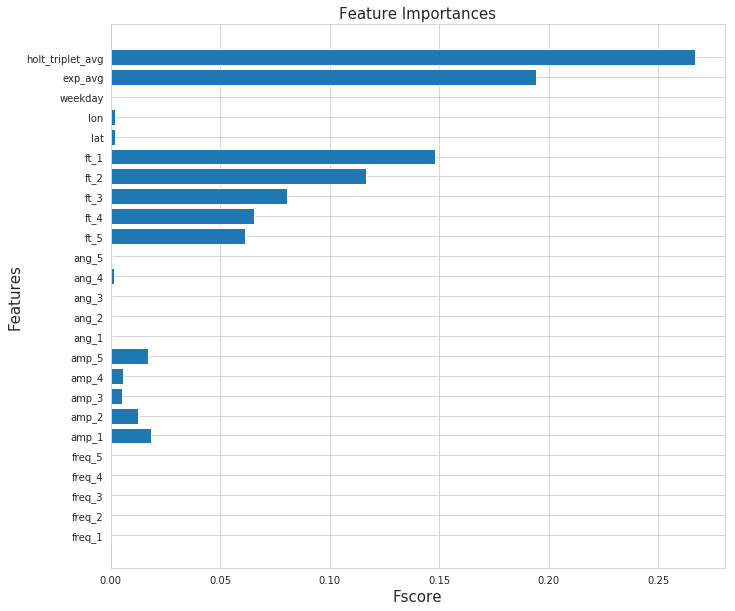

CPU times: user 2min 12s, sys: 2.8 s, total: 2min 15s
Wall time: 2min 14s


In [357]:
%%time
model_summ_local,clf=test_performance_xgb(train, y_train, test, y_test,\
                                      params_, model_summary, model_name[2],\
                                      summary=True,regressor_used='rf')


#### [3.4] Model Summary:

In [358]:
#MODEL SUMMARY
print(model_summ_local)

+-------------------------+-------------+------------+
|          Model          | Train(MAPE) | Test(MAPE) |
+-------------------------+-------------+------------+
| RANDOM-FOREST-REGRESSOR |   0.77336   |  2.30103   |
+-------------------------+-------------+------------+


# =============================================================

## 4. XGBOOST:

#### [4.1]Hyperparameter Tunnning: 

In [359]:
%%time
#TRAIN AND TEST DATA FOR XGBOOST MODELS
train, test = x_train, x_test
y_train, y_test = tsne_train_output, tsne_test_output
print('HYPERPARAMETER:\n')
param_list(params_range_xgb, param_summ)
print()
model, params_ = tuneALL_PARAM_XGB(train, y_train, TBS, params_range_xgb, params_xgb, searchMethod[0],'xgb')

HYPERPARAMETER:

+------------------+-------------------------------+
|    Parameter     |             Value             |
+------------------+-------------------------------+
|   n_estimators   |      [128, 256, 512, 650]     |
|    max_depth     |           [5, 7, 9]           |
| min_child_weight |           [1, 3, 5]           |
|      gamma       |   [0.0, 0.1, 0.2, 0.3, 0.4]   |
|    subsample     |      [0.6, 0.7, 0.8, 0.9]     |
| colsample_bytree |      [0.6, 0.7, 0.8, 0.9]     |
|    reg_alpha     | [0, 0.001, 0.005, 0.01, 0.05] |
+------------------+-------------------------------+

Tunning N_ESTIMATORS:
Train MAPE: 1.0634 CV MAPE: 1.2637
Train MAPE: 0.9383 CV MAPE: 1.1785
Train MAPE: 0.8361 CV MAPE: 1.1628
Train MAPE: 0.7950 CV MAPE: 1.1622

Tunning MAX_DEPTH:
Train MAPE: 0.7950 CV MAPE: 1.1622
Train MAPE: 0.5476 CV MAPE: 1.2088
Train MAPE: 0.2923 CV MAPE: 1.2275

Tunning MIN_CHILD_WEIGHT:
Train MAPE: 0.7950 CV MAPE: 1.1622
Train MAPE: 0.8068 CV MAPE: 1.1519
Train MAPE: 0.8

#### [4.2]Optimal value of parameters after tunning:

In [360]:
print('Optimal Value of Hyperparameters after Tunning:\n')
param_list(params_,param_summ)


Optimal Value of Hyperparameters after Tunning:

+------------------+-------+
|    Parameter     | Value |
+------------------+-------+
|   n_estimators   |  650  |
|    max_depth     |   5   |
| min_child_weight |   5   |
|      gamma       |  0.4  |
|    subsample     |  0.8  |
| colsample_bytree |  0.8  |
|    reg_alpha     | 0.005 |
+------------------+-------+


#### [4.3]Test performance :

FOR OPTIMAL PARAMETERS, TRAIN MAPE: 0.87329,  TEST MAPE: 1.13973


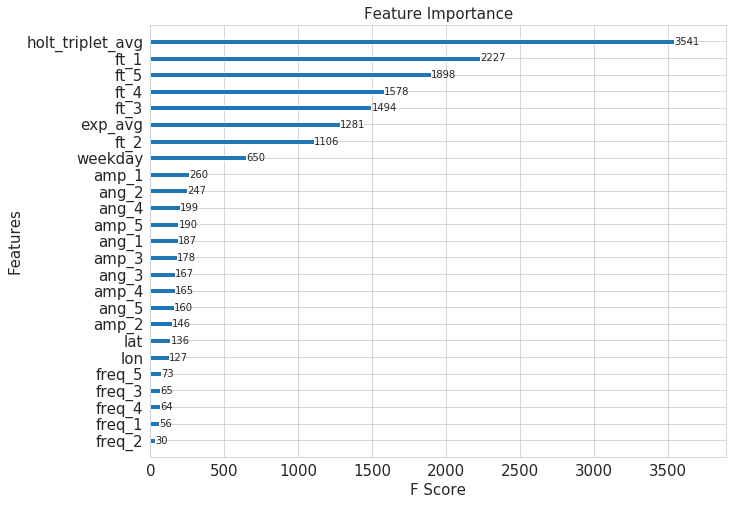

CPU times: user 1min 16s, sys: 1.89 s, total: 1min 18s
Wall time: 1min 15s


In [361]:
%%time
model_summ_local=test_performance_xgb(train, y_train, test, y_test,\
                                      params_, model_summary, model_name[3],\
                                      summary=True,regressor_used='xgb')

#### [4.4] Model Summary:

In [362]:
#MODEL SUMMARY
print(model_summ_local)

+-------------------+-------------+------------+
|       Model       | Train(MAPE) | Test(MAPE) |
+-------------------+-------------+------------+
| XGBOOST-REGRESSOR |   0.87329   |  1.13973   |
+-------------------+-------------+------------+


# =============================================================

# Conclusion:

In [363]:
print(model_summary)

+-------------------------+-------------+------------+
|          Model          | Train(MAPE) | Test(MAPE) |
+-------------------------+-------------+------------+
|    HOLTS-WINTER_MODEL   |    3.2515   |   3.3127   |
|    EWMA-PREVIOUS-DATA   |   12.1853   |  12.0552   |
|     LINEAR-REGRESSOR    |   8.68103   |  9.01357   |
| RANDOM-FOREST-REGRESSOR |   0.77336   |  2.30103   |
|    XGBOOST-REGRESSOR    |   0.87329   |  1.13973   |
+-------------------------+-------------+------------+


#### Got best performance with model:
        2. XGBOOST:
            a. Train MAPE : 0.873
            b. Test MAPE  : 1.139

## Procedure:
1. We have to solve the problem, where we have to predict no. of pickups at a given loction of NewYork City in 10 minute interval .
2. We can pose this problem as: 
        a. Time-Series Forecasting(using past data predict fucture)
        b. Regression
3. To proceed this problem we are used an approach where we divide the whole NewYork city into regions/area. So that we can predict the No. of pickups in that area and that area should be that much large only that a taxi/cab can move to that area in 10 minute of interval.
4. We used data:
        a. jan 2015 as training data
        b. jan 2016 as test data
        Note: for Baseline models we use past data of 2016.
5. We proceed with loading the dataset and with basic details of the dataset:
        a. How many datapoints present in dataset?
        b. How many features present in dataset?
6. As we have raw data so we did data analysis and data cleaning:
        a. Removal of outliers in dataset:
                -> Coordinates (longitude and latitude) lies outside of NewYork.
                -> According to guidelines trip taking more than 12 hrs are not allowed.
                -> Maximum cost of trip is 1000 etc.
7. Further analysis we divided NewYork city into regions and Whole january month into 10 minute bins(total bins=`)
8. From Step 7 for every region, we got region-cordinates(centroid(lat., lon.) or label) and 10 minute time bin(index of 10 mint interval). 
9. Training data(i.e. jan 2015 data) for every data point we attach region label and time bin(10mint time bin).
10. Now we grouped training data based on region lable and time bin to find no. of pickups in a region at particular time bin.(ex. reg=1, timebin=22, #pickups=95 and reg=1, timebin=25, #pickups=86)
11. But there is a problem, some of the timebins in a region have zero pickups and if we predict zero pickups for a cab it doesnt make any sense.(reg=1 at timebin=89, #pickups=0 giving a information that zero pickups are there is not of any use for cab driver)
12. So to solve this problem we have 2-methods:
        a. fill zero: fill zero-pickups for a timebin not present for a cluster (use this approach for test data )
        b. fill smoothing : we fill with average of pickups from neigboring timebin(use this for training data bcz in this we look at future data)
13. We build Baseline models by using previous data or ratios features:
        a. -> SMA-Ratios(simple moving average)
           -> SMA-Predictions
        b. -> WMA-Ratios (weighted moving average)
           -> WMA-Predictions
        c. -> EWMA-Ratios(exponential weighted moving average)
           -> EWMA-Predictions
14. We preare data for regression models:
        a. We used no. of pickups happened in previous 5 timebins as 5 new features.
        b. EWMA-Predictions model output as a feature for our regression model.
        c. HOLTS WINTER model o/p as a new feture for our regression model.
        d. Cluster/Region centroid latitude and longitude as a feature.
        e. day of week of pickup.
15. By plotting TimeSeries Pickup data we observe that our TimeSeries data have repetative nature, Whenever a wave have repetative nature we use Fourier transform to build new features.
16. We applied DFT(using FFT algorithm) and created new features:
        a. top 5 peaks present in Digital signal.
        b. frequencies corresponds to that peaks.
        c. angle corresponds to that peaks. 
17. We build Regression models on the prepared data(with 24 feature):
        a. Linear Regression
        b. Random Forest Regression 
        c. XGBOOST(GBDT)

Reference Links:
1. https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
2. https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/
3. https://www.appliedaicourse.com/
4. http://snowball.millersville.edu/~adecaria/ESCI386P/esci386-lesson17-Fourier-Transforms.pdf
5. http://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/